# Aprendizado de Máquina para diferenciar viadutos de pontes e estradas

## Autor
**Nome**: Pedro Lucas Cassiano Martins<br>
**Matrícula**: 190036567<br>
**Github**: [PedroLucasCM](github.com/PedroLucasCM)

## Resumo
<p>O aprendizado de Máquina vem crescendo muito no mercado desde a última decada e é uma área da computação/informática muito estudada também, por isso estamos estudando essa área no curso de Engenharia de Software na Faculdade do Gama da Universidade de Brasília.</p>
<p>Esse artigo foi criado no intuito de dar início neste estudo, criando aqui uma máquina que consiga distinguir imagens de outras, seperando-as em categoria e a treinando para conseguir uma maior precisão na distinção das imagens e concluímos então, que a máquina em pouco tempo consegue ter um grande sucesso nessa tarefa.</p>
<p>**O estudo é majoritariamente baseado no curso "_fast.ai_" de Jeremy Howard, mencionado na blibliografia desse artigo.**</p>

## Objetivo
<p>O objetivo deste artigo é o de construir/criar um modelo capaz de diferenciar e reconhecer alguns dos caminhos/passagens utilizadas por automóveis, destacando principalmente o viaduto. Um viaduto é, segundo o dicionário de Oxford, uma "via ou espécie de ponte apoiada em grandes arcos geralmente de concreto ou aço, construída para transpor vales ou outras grandes depressões de terreno, ou para sobrepor-se a uma outra via (rodovia ou ferrovia)".</p>

## Etapa 0: Atualizar o pip/fastai

In [17]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Etapa 1: Baixar imagens de diferentes caminhos
Primeiramente, importamos algumas bibliotecas e criamos a função search_images (pega do modelo original).

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Depois, procuramos imagens de viadutos. Nesse caso, pesquisei por três imagens.

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('viaduct photos', max_images=3)
urls[2]

Searching for 'viaduct photos'


'https://www.inverglenguesthouse.co.uk/wp-content/uploads/2018/03/glenfinnanviaduct.jpg'

Então baixamos uma das imagem para poder visualiza-la. No exemplo, baixei a segunda imagem

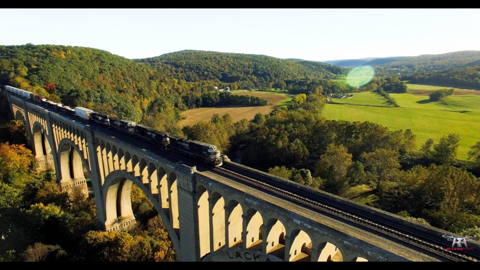

In [12]:
from fastdownload import download_url
dest = 'viaduct.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(480,480)

E por último nessa etapa, procuramos por 4 (quatro) tipos de estrada ou caminho: "rua", "viaduto", "ponte" e "estrada", nessa ordem. Porém, pesquisamos com alguns adjetivos a mais. Cada uma será pesquisa 5 vezes com os seguintes adjetivos respectivamente, para cada vez: "com veículo", "água", "céu", "sol" e "sombra". Com um tamanho máximo de 480 pixels.

In [6]:
searches = 'street', 'viaduct', 'bridge', 'road'
path = Path('viaduct_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} with vehicles photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} water photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sky photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    resize_images(path/o, max_size=480, dest=path/o)

Searching for 'street with vehicles photo'
Searching for 'street water photo'
Searching for 'street sky photo'
Searching for 'street sun photo'
Searching for 'street shade photo'
Searching for 'viaduct with vehicles photo'
Searching for 'viaduct water photo'
Searching for 'viaduct sky photo'
Searching for 'viaduct sun photo'
Searching for 'viaduct shade photo'
Searching for 'bridge with vehicles photo'
Searching for 'bridge water photo'
Searching for 'bridge sky photo'
Searching for 'bridge sun photo'
Searching for 'bridge shade photo'
Searching for 'road with vehicles photo'
Searching for 'road water photo'
Searching for 'road sky photo'
Searching for 'road sun photo'
Searching for 'road shade photo'


## Etapa 2: Treinando o modelo
Primeiro é necessário remover fotos baixadas que tiveram erros e vieram quebradas para não ter impacto no treinamento de nosso modelo. A saída mostra quantas imagens foram retiradas.

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

Para treinar um modelo, precisaremos de DataLoaders, que é um objeto que contém um conjunto de treinamento (as imagens usadas para criar um modelo) e um conjunto de validação (as imagens usadas para verificar a precisão de um modelo - não usado durante o treinamento). No fastai, podemos criar isso facilmente usando um DataBlock e visualizar amostra de imagens a partir dele:

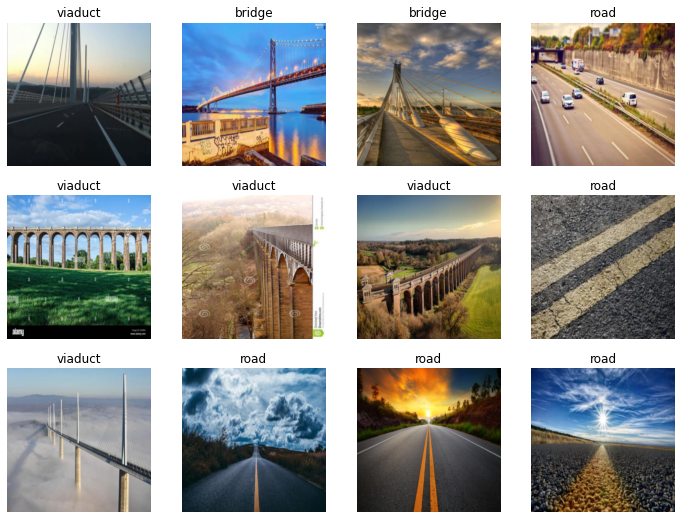

In [13]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(360, method='squish')]
).dataloaders(path, bs=32, pin_memory=False)

dls.show_batch(max_n=12)

Aqui está o que cada um dos parâmetros DataBlock significa:

> blocks=(ImageBlock, CategoryBlock),

As entradas para o nosso modelo são imagens e as saídas são categorias (neste caso,"rua", "viaduto", "ponte" ou "estrada").

> get_items=get_image_files,

Para encontrar todas as entradas para o nosso modelo, execute a função _get_image_files_ (que retorna uma lista de todos os arquivos de imagem em um caminho).

> splitter=RandomSplitter(valid_pct=0.2, seed=42),

Divida os dados em conjuntos de treinamento e validação aleatoriamente, usando 20% dos dados para o conjunto de validação.

> get_y=parent_label,

Os rótulos (valores y) são o nome do pai de cada arquivo (ou seja, o nome da pasta em que estão, que será viaduto ou não).

> item_tfms=[Resize(192, method='squish')]

Antes do treinamento, redimensione cada imagem para 360x360 pixels "espremendo-a" (squish) (em vez de cortá-la (crop)).

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais rápido e amplamente utilizado é o resnet50. Você pode treiná-lo em poucos minutos, mesmo em uma CPU! (Em uma GPU, geralmente leva menos de 10 segundos...)

O fastai vem com um método útil _fine_tune()_ que automaticamente usa as melhores práticas para ajustar um modelo pré-treinado, então usaremos isso.

## Treinando o Modelo
Aqui treinamos nosso modelo com um total de 12 iterações para maior número de treinos.

In [14]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time
0,1.579953,1.420097,0.388889,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.549969,1.300040,0.296296,00:07
1,0.416423,1.225832,0.296296,00:07
2,0.413800,1.796695,0.324074,00:07
3,0.434832,1.806755,0.333333,00:07
4,0.382756,1.996078,0.314815,00:07
5,0.347999,1.528524,0.314815,00:07
6,0.293784,1.451849,0.324074,00:07
7,0.258044,1.497292,0.305556,00:07
8,0.216739,1.505534,0.287037,00:07
9,0.179444,1.503620,0.287037,00:07


Utilizar o "_Fine-tunning_" em um modelo significa que estamos começando com um modelo que outra pessoa treinou usando algum outro conjunto de dados (chamado de *modelo pré-treinado*) e ajustando um pouco os pesos para que o modelo aprenda a reconhecer seu conjunto de dados específico . Nesse caso, o modelo pré-treinado foi treinado para reconhecer fotos em *imagenet* e um conjunto de dados de visão computacional amplamente utilizado com imagens abrangendo 1.000 categorias)

## Passo 3: Testando o modelo
Com o modelo treinado, basta executar a última tela e será retornado um prompt informando qual dos vários tipos pesquisados é a imagem, uma probabilidade de ser o tipo de caminho/rodovia procurada e a imagem dela.

É um caminho: viaduct.
Probabilidade de ser do tipo viaduct: 99.94%


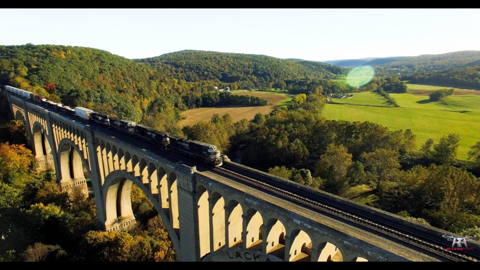

In [15]:
viaduct_or_not,_,probs = learn.predict(PILImage.create('viaduct.jpg'))
print(f"É um caminho: {viaduct_or_not}.")
print(f"Probabilidade de ser do tipo {viaduct_or_not}: {probs.sort()[0][-1]*100:.2f}%")
Image.open('viaduct.jpg').to_thumb(480,480)

## Conclusão

Com isso, podemos ver que a máquina conseguiu diferenciar viadutos de outros caminhos, havendo claro alguns erros porém tendo uma taxa de quase mais de 90% de acurácia no teste do modelo.
Observa-se que fazer uma testagem nesse modelo tentando diferenciar diversos objetos diferentes porém iguais torna-se um pouco mais difícil do que tentar diferenciar apenas 2 objetos, podendo haver mais erros no treinamento da máquina. Entretanto, com o treinamento vai se tornando mais e mais preciso o reconhecimento das imagens pela máquina.

## Bibliografia
Howard, Jeremy. Practical Deep Learning for Coders, 2022. Disponível em: https://course.fast.ai/. Acesso em: 02 de abr. de 2023. <br>
Howard, Jeremy. Lesson 1: Getting Started, 2022. Disponível em: https://course.fast.ai/Lessons/lesson1.html. Acesso em: 02 de abr. de 2023.<br>
Howard, Jeremy. Lesson 1: Practical Deep Learning for Coders 2022, 2022. Disponível em: https://www.youtube.com/watch?v=8SF_h3xF3cE. Acesso em: 02 de abr. de 2023.